In [37]:
# numpy
import numpy as np
from numpy import unravel_index
print( 'Using numpy version %s' % np.__version__ )

# system
import glob, os

# astropy
import astropy as astro
from astropy.table import Table
from astropy.io import ascii, fits
from astropy.stats import sigma_clip
from astropy.convolution import convolve_fft
import astropy.units as u
from astropy.cosmology import Planck15
from astropy.coordinates import SkyCoord
from astropy.nddata.utils import Cutout2D
from astropy.wcs import WCS

print( 'Using astropy version %s' % astro.__version__ )

Using numpy version 1.25.2
Using astropy version 6.0.1


# Generate cutout:

In [35]:
# cat_f = ascii.read('/Users/neal/Documents/PhD/projects/SED-fitting/Clump/Codes/filtered_data_table_goodss4.csv',format='csv')

In [4]:
# mosaic_file_path='/Users/neal/Documents/PhD/projects/SED-fitting/Clump/CANDELS-data/MAST-CANDELS/hlsp_candels_hst_wfc3_gs-tot_f160w_v1.0_drz.fits'

In [63]:
# Load the catalog
clump_catalog_path = '/Users/neal/Documents/PhD/projects/SED-fitting/Clump/results/catalog_n/goodsslast.csv'
clump_catalog = pd.read_csv(clump_catalog_path)


In [39]:
cat_f = ascii.read('/Users/neal/Documents/PhD/projects/SED-fitting/Clump/results/catalog_n/goodsslast.csv', format='csv')

In [27]:
clump_catalog

,Unnamed: 0,Field,CANDELS_ID,z,RA_gal,DEC_gal,A,Clump_ID,dist_clump,flux_ratio,restuv_flux,RA_clump,DEC_clump
0,0,goodss,18,2.658,53.103527,-27.956482,4.078,1,4.361886,0.223942,0.333196,53.103609,-27.956512
1,1,goodss,18,2.658,53.103527,-27.956482,4.078,2,6.206130,0.120983,0.333196,53.103571,-27.956396
2,2,goodss,31,2.667,53.103826,-27.954019,3.839,1,0.720425,0.406089,0.539943,53.103836,-27.954012
3,3,goodss,31,2.667,53.103826,-27.954019,3.839,2,6.838422,0.100441,0.539943,53.103779,-27.953912
4,4,goodss,40,1.056,53.088263,-27.954256,7.522,1,13.107481,0.010098,1.373450,53.088024,-27.954326
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4058,4058,goodss,26763,2.408,53.135199,-27.705983,5.185,-99,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000
4059,4059,goodss,26783,2.615,53.150381,-27.706844,6.065,1,7.704078,0.052889,0.742023,53.150339,-27.706978
4060,4060,goodss,26783,2.615,53.150381,-27.706844,6.065,2,1.644023,0.161235,0.742023,53.150415,-27.706878
4061,4061,goodss,26783,2.615,53.150381,-27.706844,6.065,3,6.935619,0.166425,0.742023,53.150415,-27.706745


In [28]:
clump_catalog['z'][0]

2.658

In [30]:
clump_catalog.columns

Index(['Unnamed: 0', 'Field', 'CANDELS_ID', 'z', 'RA_gal', 'DEC_gal', 'A',
       'Clump_ID', 'dist_clump', 'flux_ratio', 'restuv_flux', 'RA_clump',
       'DEC_clump'],
      dtype='object')

In [96]:
galaxy_IDS=np.unique(cat_f['CANDELS_ID'])
print(len(galaxy_IDS))

1491


In [97]:
bands = ['606', '850', '160']
length = 200  # Size of the cutout

for i in range( len( galaxy_IDS ) ):
    
    gal_id = galaxy_IDS[i]
    field = 'goodss'
    
    idx_in_catalog = np.where(cat_f['CANDELS_ID'] == gal_id)[0]

    if len(idx_in_catalog) > 1:
        coords = SkyCoord(cat_f['RA_gal'][idx_in_catalog][0], cat_f['DEC_gal'][idx_in_catalog][0], unit='deg')
    else:
        coords = SkyCoord(cat_f['RA_gal'][idx_in_catalog], cat_f['DEC_gal'][idx_in_catalog], unit='deg')
    



In [98]:
for i in range( len( galaxy_IDS ) ):
    
    gal_id = galaxy_IDS[i]
    field = 'goodss'
    
    idx_in_catalog = np.where(cat_f['CANDELS_ID'] == gal_id)[0]

    if len(idx_in_catalog) > 1:
        coords = SkyCoord(cat_f['RA_gal'][idx_in_catalog][0], cat_f['DEC_gal'][idx_in_catalog][0], unit='deg')
    else:
        coords = SkyCoord(cat_f['RA_gal'][idx_in_catalog], cat_f['DEC_gal'][idx_in_catalog], unit='deg')
    
    if field == "goodss":

        for b in bands:
            band_f_list = glob.glob('/Users/neal/Documents/PhD/projects/SED-fitting/Clump/CANDELS-data/MAST-CANDELS/*f%s*' % b)

            # Assuming the first file in the list is the one we want, 
            hdulist = fits.open(band_f_list[0])
            hdu_c = fits.open(band_f_list[0])[0]
            wcs_c = WCS(hdu_c.header)
            wcs_c.sip = None

            # create cutouts
            cutout_c = Cutout2D(hdu_c.data, coords, (length, length), wcs=wcs_c)

            # Apply the PSF matching kernel if available and not the F160W band
            if b != '160':
                kernel_f = glob.glob('/Users/neal/Documents/PhD/projects/SED-fitting/Clump/psfs/goodss_*_psf/*f%s_kernel.fits.gz' % b)
                if kernel_f:  # If a kernel file is found
                    print(f"Using kernel: {kernel_f[0]}")
                    hdu_k = fits.open(kernel_f[0])[0]
                    cutout_c.data = convolve_fft(cutout_c.data, hdu_k.data)
                    
            img_wcs = cutout_c.wcs.to_header()

            # Conversion factor to measure flux in Jy
            if b in ['125', '140', '160']:
                convert_factor = hdu_c.header.get('PHOTFNU', 'N/A')
            else:
                convert_factor = hdu_c.header.get('PHOTFLAM', 'N/A') * hdu_c.header.get('PHOTPLAM', 1) ** 2 * 1e23 / (2.99792458e18)

            # Prepare the fits file with the cutout
            hdu1 = fits.HDUList()
            hdu1.append(fits.PrimaryHDU(data=cutout_c.data, header=img_wcs))

            header = hdu1[0].header
            header['PHOT_ZP'] = (convert_factor, 'conversion factor to measure flux in Jy')

            # Write the new fits file
            new_filename = f'/Users/neal/Documents/PhD/projects/SED-fitting/Clump/Cutouts-Guo/goodss_{gal_id}_f{b}.fits'
            hdu1.writeto(new_filename, overwrite=True)

            # Clean up
            hdulist.close()
            

# Photometry code:

In [1]:
import photutils

from astropy.io import fits

from astropy.wcs import WCS
import astropy.units as u
from astropy.coordinates import SkyCoord

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from photutils.aperture import SkyCircularAperture, SkyCircularAnnulus, aperture_photometry

In [118]:
def automated_photometry(clumps, wcs, science_image,phot_zp, mask_aperture_size=0.24, annulus_inner=0.24, annulus_outer=0.36):
    results = []

    # Convert the science image to a floating point array if not already
    science_image = np.array(science_image, dtype=float)

    # Iterates over each clump
    for index, target_clump in clumps.iterrows():
        # Check if the target clump has valid coordinates. Skips processing if the DEC value of the clump is set to a (-99.0), 
        # which indicates invalid or missing data.
        if target_clump['DEC_clump'] == -99.0:
            print(f"Skipping clump due to invalid coordinates: {target_clump['CANDELS_ID']}, {target_clump['Clump_ID']}")
            continue

        # Converts the RA and DEC of the target clump to a SkyCoord object
        target_coords = SkyCoord(ra=target_clump['RA_clump']*u.degree, dec=target_clump['DEC_clump']*u.degree)

        # Creates a copy of the original image to mask out other clumps, 
        # so that they do not affect the photometry of the target clump.
        science_image_masked = np.copy(science_image)

        # Mask other clumps only if more than one clump is present, (by setting their pixel values to 0)
        if len(clumps) > 1:
            for _, other_clump in clumps.drop(index).iterrows():
                other_coords = SkyCoord(ra=other_clump['RA_clump']*u.degree, dec=other_clump['DEC_clump']*u.degree)
                mask_aperture = SkyCircularAperture(other_coords, r=mask_aperture_size*u.arcsec).to_pixel(wcs)
                mask = mask_aperture.to_mask(method='center')
                # Generates slices for numpy array indexing using the bounding box of the mask.
                bbox_slices = (slice(mask.bbox.iymin, mask.bbox.iymax), slice(mask.bbox.ixmin, mask.bbox.ixmax))
                # Accesses the section of the image to mask out.
                science_image_masked_section = science_image_masked[bbox_slices]
                mask_data = mask.data.astype(bool)

                mask_data = mask_data[
                :min(mask_data.shape[0], science_image_masked_section.shape[0]),
                :min(mask_data.shape[1], science_image_masked_section.shape[1])
                ]
                # Applies the mask to the image 
                science_image_masked_section[mask_data] = 0
                science_image_masked[bbox_slices] = science_image_masked_section
               
           
            # #plot mask
            # plt.imshow(science_image_masked)
            # plt.show()


        # Perform photometry on the target clump
        target_aperture = SkyCircularAperture(target_coords, r=0.18*u.arcsec).to_pixel(wcs)
        photometry = aperture_photometry(science_image_masked, target_aperture)

        # Check if photometry result is unexpected!(We get this since some images in some bands are just black)
        if photometry['aperture_sum'][0] == 0:
            print(f"Zero flux detected for clump: {target_clump['CANDELS_ID']}, {target_clump['Clump_ID']}")
            

        # Background subtraction
        annulus_aperture = SkyCircularAnnulus(target_coords, r_in=annulus_inner*u.arcsec, r_out=annulus_outer*u.arcsec).to_pixel(wcs)
        background = aperture_photometry(science_image_masked, annulus_aperture)
        area_annulus = annulus_aperture.area
        # Calculates the average background flux per pixel within the annulus
        background_per_pixel = background['aperture_sum'][0] / area_annulus
        # Scales the average background to the aperture size
        total_background_light = background_per_pixel * target_aperture.area
        corrected_flux = 1.5 *(photometry['aperture_sum'][0] - total_background_light) # aperture correction

        wrong_corrected_flux = (1.5 *(photometry['aperture_sum'][0])) - total_background_light

        raw_flux_mjy = (photometry['aperture_sum'][0] * phot_zp) * 1e6  # Convert from Jy to μJy
        background_flux_mjy = (total_background_light * phot_zp) * 1e6
        corrected_flux_mjy = (corrected_flux * phot_zp) * 1e6
        wrong_corrected_flux_mjy =  (wrong_corrected_flux * phot_zp) * 1e6

        # Appends the results for this clump 
        results.append({
            'CANDELS_ID': target_clump['CANDELS_ID'],
            'Clump_ID': target_clump['Clump_ID'],
            'Raw_Flux_mjy': raw_flux_mjy,
            'Background_Flux_mjy': background_flux_mjy,
            'Corrected_Flux_mjy': corrected_flux_mjy,
            'wrong_corrected_flux_mjy' :wrong_corrected_flux_mjy
        })
    # Converts the results list into a DataFrame
    return pd.DataFrame(results)


In [114]:
clump_catalog = pd.read_csv('/Users/neal/Documents/PhD/projects/SED-fitting/Clump/results/fluxratio_above5_matched_galid_normdist.csv')
# clump_catalog = pd.read_csv(clump_catalog_path)


In [109]:
clump_catalog.columns

Index(['Unnamed: 0', 'Field', 'CANDELS_ID', 'z_1', 'RA_gal', 'DEC_gal', 'A',
       'Clump_ID', 'dist_clump', 'flux_ratio',
       ...
       'CVmag', 'e_CVmag', 'logUVSFR', 'e_logUVSFR', 'UVE_B-V_', 'e_UVE_B-V_',
       'VRFlag', 'BMFlag', 'EFlag', 'Separation'],
      dtype='object', length=131)

In [110]:
clump_catalog['CANDELS_ID'].unique()

array([   40,    79,   171,   278,   300,   366,   461,   482,   627,
         669,   744,   792,   834,   898,  1054,  1237,  1339,  1356,
        1442,  1785,  1857,  1907,  2155,  2278,  2309,  2725,  2753,
        2976,  2987,  3041,  3207,  3279,  3283,  3304,  3475,  3531,
        3610,  3654,  3752,  3790,  3819,  3857,  3946,  3997,  4171,
        4204,  4216,  4244,  4634,  4701,  4862,  4901,  5022,  5145,
        5190,  5221,  5365,  5552,  5563,  5682,  5761,  5792,  6513,
        6655,  6714,  7145,  7183,  7572,  7705,  7806,  7828,  7837,
        7935,  7941,  8240,  8284,  8353,  8409,  8555,  8736,  8902,
        9024,  9246,  9480,  9527,  9601,  9717,  9746,  9834, 10457,
       10469, 10493, 10496, 10702, 10727, 11006, 11597, 11725, 12858,
       13689, 13751, 13787, 15565, 15898, 16041, 16082, 16099, 16232,
       16385, 16412, 16455, 16474, 16616, 17265, 17316, 17376, 17673,
       17824, 18095, 18393, 18471, 18489, 19051, 19186, 19329, 19496,
       19504, 19549,

In [121]:
import os

# List of bands 
bands = [ 'f160', 'f606', 'f850']

# Initialize a dictionary to hold the WCS objects and science image data for each band
wcs_dict = {band: {} for band in bands}
image_data_dict = {band: {} for band in bands}
phot_zp_dict ={band: {} for band in bands}



# Populate the dictionaries with WCS and image data for each band and galaxy
for candels_id in clump_catalog['CANDELS_ID'].unique()[:10]:

    # if candels_id == 40:
    #     pass
    # else:
    #     continue


    
    for band in bands:
        fits_path = f'/Users/neal/Documents/PhD/projects/SED-fitting/Clump/Cutouts-Guo/goodss_{candels_id}_{band}.fits'
        # print(f"Looking for FITS file at path: {fits_path}")  # Print the expected file path
        
        # Check if the FITS file exists
        if os.path.exists(fits_path):
          
            with fits.open(fits_path) as hdul:
                wcs_dict[band][candels_id] = WCS(hdul[0].header)
                image_data_dict[band][candels_id] = hdul[0].data
       
      

                # Read the conversion factor from the header
                if 'PHOT_ZP' in hdul[0].header:
                    phot_zp_dict[band][candels_id] = hdul[0].header['PHOT_ZP']
                else:
                    print(f"PHOT_ZP keyword not found in header of {fits_path}. Using default value.")
                   
                    phot_zp_dict[(candels_id, band)] = phot_zp

# Perform photometry for each band and galaxy, and add results to the catalog
for candels_id in clump_catalog['CANDELS_ID'].unique()[:10]:
    galaxy_clumps = clump_catalog[(clump_catalog['CANDELS_ID'] == candels_id) & (clump_catalog['DEC_clump'] <= 90) & (clump_catalog['DEC_clump'] >= -90)].copy()
    
    for band in bands:
        # Check if the galaxy has data in this band
        if candels_id in wcs_dict[band] and candels_id in image_data_dict[band]:
            wcs = wcs_dict[band][candels_id]
            science_image = image_data_dict[band][candels_id]
            phot_zp = phot_zp_dict[band][candels_id]  # Get the photometric zero point for the current band and galaxy

            # Check if the science image is not empty or  black
            if not np.all(science_image == 0):
                photometry_results = automated_photometry(galaxy_clumps, wcs, science_image,phot_zp)
                
                
                #  Update the original clump_catalog with the converted flux results
                for index, row in photometry_results.iterrows():
                    mask = (clump_catalog['CANDELS_ID'] == row['CANDELS_ID']) & (clump_catalog['Clump_ID'] == row['Clump_ID'])
                    clump_catalog.loc[mask, f'Raw_Flux_{band}_mjy'] = row['Raw_Flux_mjy']
                    clump_catalog.loc[mask, f'Background_Flux_{band}_mjy'] = row['Background_Flux_mjy']
                    clump_catalog.loc[mask, f'Corrected_Flux_{band}_mjy'] = row['Corrected_Flux_mjy']
                    clump_catalog.loc[mask, f'wrong_corrected_flux_{band}_mjy'] = row['wrong_corrected_flux_mjy']


# Save the updated clump catalog with photometry results
clump_catalog.to_csv('/Users/neal/Documents/PhD/projects/SED-fitting/Clump/results/10clumps_onGuocutout_photometrycode.csv', index=False)


In [135]:
image_hdu=fits.open('/Users/neal/Documents/PhD/projects/SED-fitting/Clump/Cutouts-Guo/goodss_18_f160.fits')
science_image = image_hdu[0].data
wcs_435 = WCS(image_hdu[0].header)
image_hdu.close()


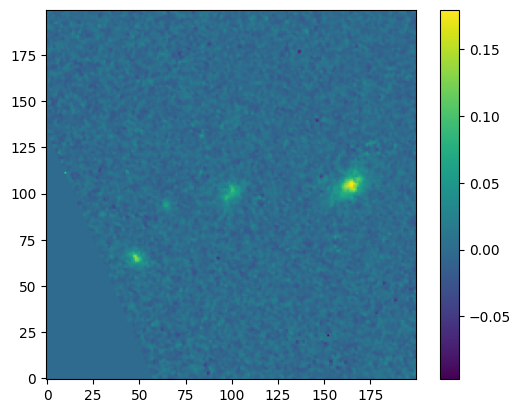

In [136]:
plt.imshow(science_image, origin='lower')
plt.colorbar()
plt.show()

In [137]:
ex_data= clump_catalog[(clump_catalog['CANDELS_ID'] == 40) & (clump_catalog['Clump_ID'] == 3)]
# ex_data_2= goodss[(goodss['CANDELS_ID'] == 18) & (goodss['Clump_ID'] == 2)]
ra_dec_clump1 =ex_data[['RA_clump', 'DEC_clump']]

In [129]:
ex_data

,Unnamed: 0,Field,CANDELS_ID,z_1,RA_gal,DEC_gal,A,Clump_ID,dist_clump,flux_ratio,...,EFlag,Separation,Raw_Flux_f160_mjy,Background_Flux_f160_mjy,Corrected_Flux_f160_mjy,Raw_Flux_f850_mjy,Background_Flux_f850_mjy,Corrected_Flux_f850_mjy,wrong_corrected_flux_f160_mjy,wrong_corrected_flux_f850_mjy
0,6,goodss,40,1.056,53.088263,-27.954256,7.522,3,3.104199,0.055789,...,0,0.317233,0.785659,0.706369,0.118934,NaN,NaN,NaN,0.472119,NaN


In [138]:
coords = SkyCoord(ra=ra_dec_clump1['RA_clump'], dec=ra_dec_clump1['DEC_clump'], unit='deg')

In [147]:
coords

<SkyCoord (ICRS): (ra, dec) in deg
    [(53.08821295, -27.95420938)]>

In [139]:
aper_sky = photutils.SkyCircularAperture(positions=coords, r=0.18 * u.arcsec)
aper = aper_sky.to_pixel(wcs=wcs_435)


/var/folders/by/26kj85kd3w94p3xv_m2206b40000gn/T/ipykernel_76342/2668147189.py:1: DeprecationWarning: `photutils.SkyCircularAperture` is a deprecated alias for `photutils.aperture.SkyCircularAperture` and will be removed in the future. Instead, please use `from photutils.aperture import SkyCircularAperture` to silence this warning.
  aper_sky = photutils.SkyCircularAperture(positions=coords, r=0.18 * u.arcsec)


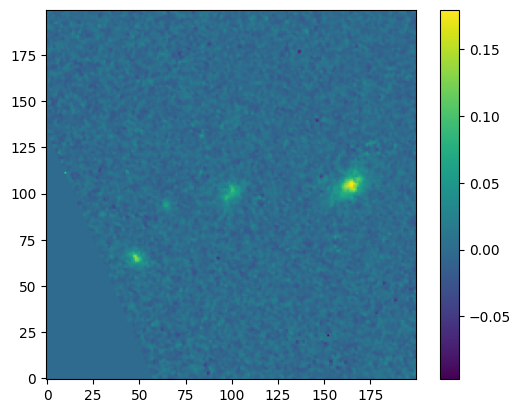

In [146]:
plt.imshow(science_image, origin='lower')
plt.colorbar()

aper.plot(color="red", lw=2., fill=False)
plt.show()

In [89]:
import os
from astropy.io import fits

# Select the specific CANDELS ID and band to check
selected_candels_id = 18  # Example CANDELS ID, replace with the one you want to check
selected_band = 'f160'  # Example band, change it if needed

fits_path = f'/Users/neal/Documents/PhD/projects/SED-fitting/Clump/Cutouts-Guo/goodss_{selected_candels_id}_{selected_band}.fits'

# Check if the FITS file exists
if os.path.exists(fits_path):
    with fits.open(fits_path) as hdul:
        phot_zp = hdul[0].header.get('PHOT_ZP', None)
        
        if phot_zp is not None:
            print(f"PHOT_ZP value for galaxy {selected_candels_id} in band {selected_band}: {phot_zp}")
        else:
            print(f"PHOT_ZP keyword not found in header of {fits_path}.")
else:
    print(f"FITS file for galaxy {selected_candels_id} in band {selected_band} not found.")


PHOT_ZP value for galaxy 18 in band f160: 1.5053973e-07
